<a href="https://colab.research.google.com/github/MKhizerButt/Application-Specific-Embedded-Processor-using-System-Verilog/blob/main/fraud_detection_2_balance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<hr style="width: 50%; border: 2px solid #555;">
<img style="float:left" src="https://phd.cs.rptu.de/logos/RPTU-2h-800x205-col.png" width="200">
<img style="float:right" src="https://yt3.googleusercontent.com/ytc/AIdro_mlQBuKwvDcnLdRTOLC913IXmKttYJAqjEvXotmQTKaqw=s900-c-k-c0x00ffffff-no-rj" width="200" height="70">
</center>

<center >
<!-- <hr style="width: 50%; border: 2px solid #555;"> -->
<h3 style="margin-top: 5px;"></h3>
<h3 style="margin-top: 5px;">Embedded Machine Learning - RPTU</h3>
<h1 style="margin-bottom: 0;">Exercise 2-b : Fraud Detection - Balanced</h1>
<hr style="width: 50%; border: 2px solid #555;">
</center>

# Introduction:

In our previous notebook, we built an SVM classifier for fraud detection and evaluated its performance using a confusion matrix.

While our model achieved high overall accuracy by correctly identifying legitimate transactions, it completely failed to detect any fraudulent transactions. The model essentially learned to classify everything as legitimate, which defeats the entire purpose of fraud detection.

This problem stems from **class imbalance** in our dataset. In real-world fraud detection scenarios, fraudulent transactions typically represent less than 1% of all transactions. Our dataset reflects this reality, with legitimate transactions vastly outnumbering fraudulent ones.

When trained on such imbalanced data, machine learning models tend to be biased toward the majority class (legitimate transactions). The model "learns" that predicting everything as legitimate yields high accuracy, even though it provides no value for our actual goal of catching fraud.

>**Why Balancing Matters:**<br><br>
Addressing class imbalance is crucial because:
>- **Business Impact:** Missing fraudulent transactions (false negatives) results in direct financial losses
>- **Model Utility:** A model that can't detect fraud is useless, regardless of its accuracy score
>- **Fair Representation:** The model needs adequate exposure to both classes to learn meaningful patterns that distinguish fraud from legitimate activity

<br>

In this notebook, we'll enhance our preprocessing stage by adding a class balancing step before training our SVM model. This will help the model learn to recognize fraudulent patterns effectively while maintaining good performance on legitimate transactions.

# 1. Setup

In [ ]:
!pip install datasets

In [ ]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# 2. Understanding the Data
We load [the fraud detection dataset](https://huggingface.co/datasets/Nooha/cc_fraud_detection_dataset), and explore the feature information and class distribution.

In [ ]:
# Load the dataset
ds = load_dataset("Nooha/cc_fraud_detection_dataset")
df = ds['train'].to_pandas()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/948 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/91.2M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/91.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2646694 [00:00<?, ? examples/s]

In [ ]:
# Data Exploration
print("Dataset Overview:")
print("Shape:", df.shape)
print("\nFeature Information:")
df.info()

Dataset Overview:
Shape: (2646694, 20)

Feature Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646694 entries, 0 to 2646693
Data columns (total 20 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ssn         object 
 1   cc_num      int64  
 2   first       object 
 3   last        object 
 4   gender      object 
 5   city        object 
 6   state       object 
 7   zip         int64  
 8   city_pop    int64  
 9   job         object 
 10  dob         object 
 11  acct_num    int64  
 12  trans_num   object 
 13  trans_date  object 
 14  trans_time  object 
 15  unix_time   int64  
 16  category    object 
 17  amt         float64
 18  is_fraud    int64  
 19  merchant    object 
dtypes: float64(1), int64(6), object(13)
memory usage: 403.9+ MB


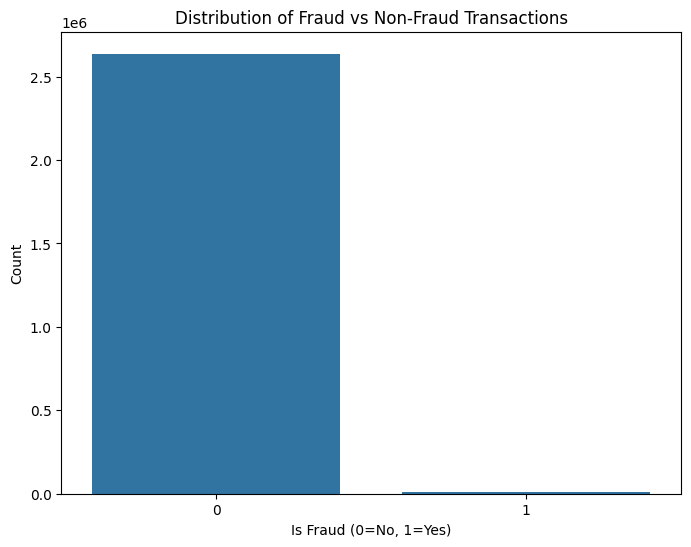

In [ ]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='is_fraud')
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.xlabel('Is Fraud (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

# 3. Data Preprocessing

Building on our previous exercise, we'll perform the same preprocessing steps with two main additions - **handling class imbalance** and **feature scaling**. This enhanced preprocessing pipeline will help our model learn to detect fraudulent transactions effectively.

>**1. Handling Class Imbalance:**<br>
This is the key enhancement to the preprocessing pipeline. As we discovered in the previous exercise, the extreme imbalance between legitimate and fraudulent transactions caused our model to ignore fraud entirely. To address this, we'll apply resampling techniques to balance the training data.

>**2. Feature Selection - Dropping Irrelevant Columns:**
As before, we remove irrelevant features such as transaction IDs and redundant information to keep only the predictive variables.

>**3. Encoding Categorical Variables:**
We convert categorical features (location names, genders, etc.) into numerical representations using encoding techniques like Label Encoding or One-Hot Encoding.

>**4. Data Split:**
We divide our dataset into training and test sets to evaluate model performance on unseen data.


>**5. Feature Scaling - Standardization:**
Before training our SVM, we apply feature scaling using **StandardScaler**, which standardizes features by removing the mean and scaling to unit variance. This transformation ensures all features are on the same scale.
>
>**Why is Feature Scaling Important?**
>- **Different Scales:** Transaction features often have vastly different ranges (e.g., transaction amount might range from \$1 to \$10,000, while a binary encoded feature ranges from 0 to 1)
>- **SVM Sensitivity:** SVMs are distance-based algorithms that are highly sensitive to feature scales. Features with larger numerical ranges can dominate the distance calculations, causing the model to overlook important patterns in smaller-scale features
>- **Improved Performance:** Scaling ensures all features contribute proportionally to the model's learning process, leading to faster convergence and better performance

>
>By balancing our training data, we give the model equal opportunity to learn patterns from both fraudulent and legitimate transactions, enabling it to detect fraud rather than simply defaulting to the majority class.

In [ ]:
# Handle class imbalance
def balance_dataset(df, target_col, sample_size=10000): # &&& Sample size is 10k hence we get 10k samples per is_fraud values (0/1)
  # Separate classes
  df_class_0 = df[df[target_col] == 0]
  df_class_1 = df[df[target_col] == 1]

  # Resample each class
  df_balanced_0 = df_class_0.sample(n=sample_size, random_state=42)
  df_balanced_1 = df_class_1.sample(n=sample_size, replace=True, random_state=42)

  # Combine and shuffle
  df_balanced = pd.concat([df_balanced_0, df_balanced_1])
  return df_balanced.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [ ]:
df_balanced = balance_dataset(df, 'is_fraud')

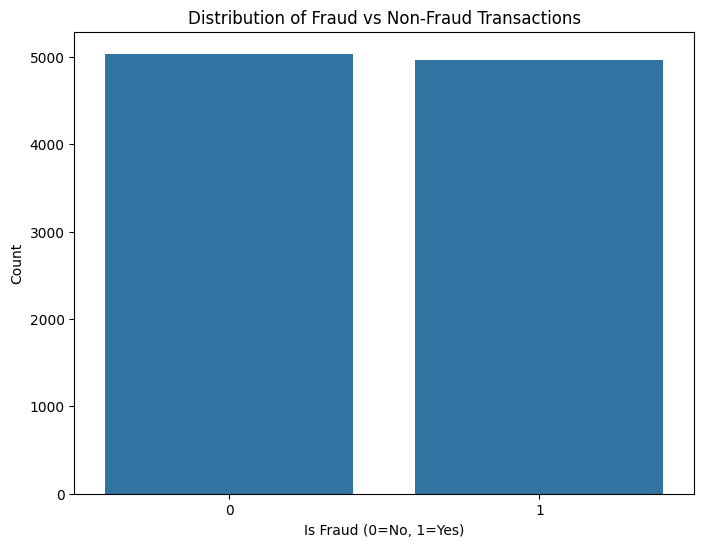

In [ ]:
# Visualize class distribution after balancing
plt.figure(figsize=(8, 6))
sns.countplot(data=df_balanced, x='is_fraud')
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.xlabel('Is Fraud (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

In [ ]:
# Feature preprocessing
def preprocess_features(df):
  # Drop unnecessary columns
  columns_to_drop = ['first', 'last', 'ssn', 'dob', 'trans_num',
                    'trans_date', 'trans_time', 'is_fraud']
  X = df.drop(columns=columns_to_drop)

  # Get list of categorical columns
  categorical_columns = X.select_dtypes(exclude=['int64', 'float64']).columns

  # Convert all categorical variables to dummy variables
  X = pd.get_dummies(X, columns=categorical_columns, drop_first=True) # &&& drops the first column as if column b and c are 0, it points to column a

  return X

In [ ]:
# Prepare features and target
X = preprocess_features(df_balanced)
y = df_balanced['is_fraud']

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Visualizing Feature Scaling with Box Plots:**

To understand the impact of StandardScaler on our features, we use **box plots** - a statistical visualization that displays the distribution of numerical data and highlights key summary statistics.

**How to Read a Box Plot:**

>Each box plot shows five key statistics for a feature:<br>
  >- **The Box:** Represents the middle 50% of the data (Interquartile Range - IQR)
  >- **Bottom edge:** 25th percentile (Q1) - 25% of data falls below this value
  >- **Line inside box:** Median (50th percentile) - the middle value of the dataset
  >- **Top edge:** 75th percentile (Q3) - 75% of data falls below this value
  >- **The Whiskers:** Lines extending from the box showing the range of typical values (usually 1.5 × IQR from the box edges)
  >- **Outliers:** Individual points beyond the whiskers, representing unusual or extreme values

In [ ]:
# Feature selection
def select_demo_features(df):
  X = df[["cc_num" , "zip" , "city_pop" , "acct_num" , "unix_time" , "amt" , "gender_M"]]
  return X

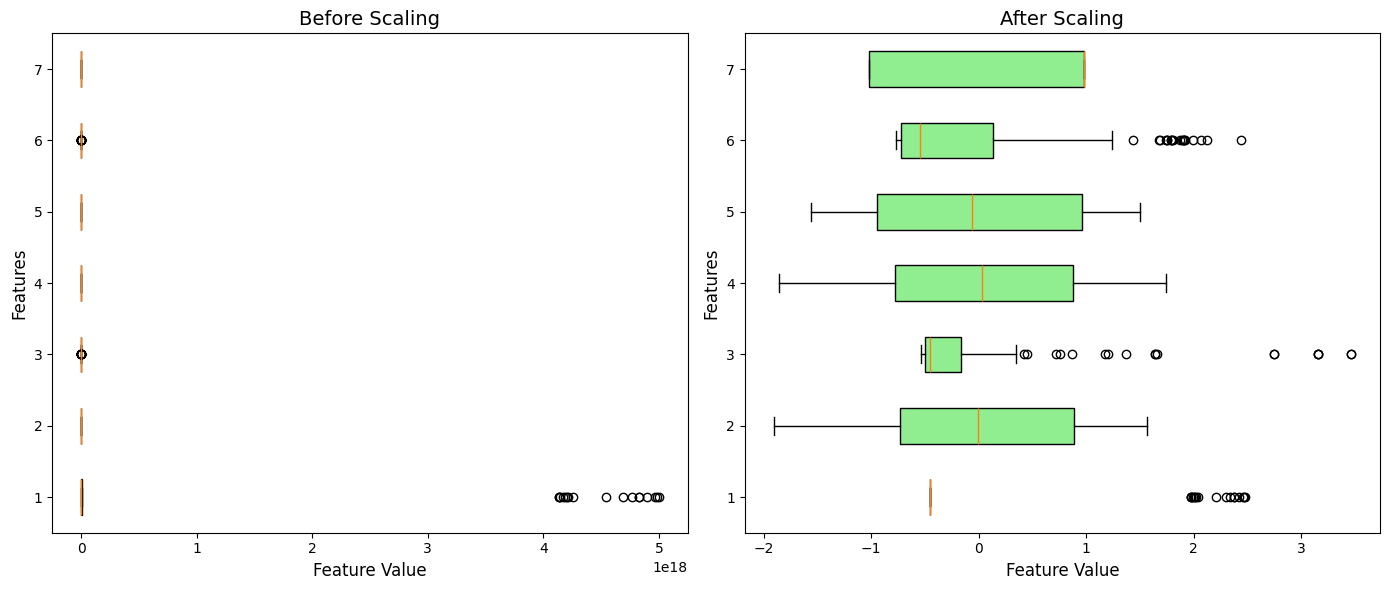

In [ ]:
# Simulate example data (or use your X_train and X_train_scaled)
X_train_sample = select_demo_features(X_train[:100])  # Use a subset for visualization if the dataset is large
scaler = StandardScaler()
X_train_scaled_sample = scaler.fit_transform(X_train_sample)

# Plot before and after scaling
plt.figure(figsize=(14, 6))

# Plot before scaling
plt.subplot(1, 2, 1)
plt.boxplot(X_train_sample, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Before Scaling', fontsize=14)
plt.xlabel('Feature Value', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Plot after scaling
plt.subplot(1, 2, 2)
plt.boxplot(X_train_scaled_sample, vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('After Scaling', fontsize=14)
plt.xlabel('Feature Value', fontsize=12)
plt.ylabel('Features', fontsize=12)

plt.tight_layout()
plt.show()

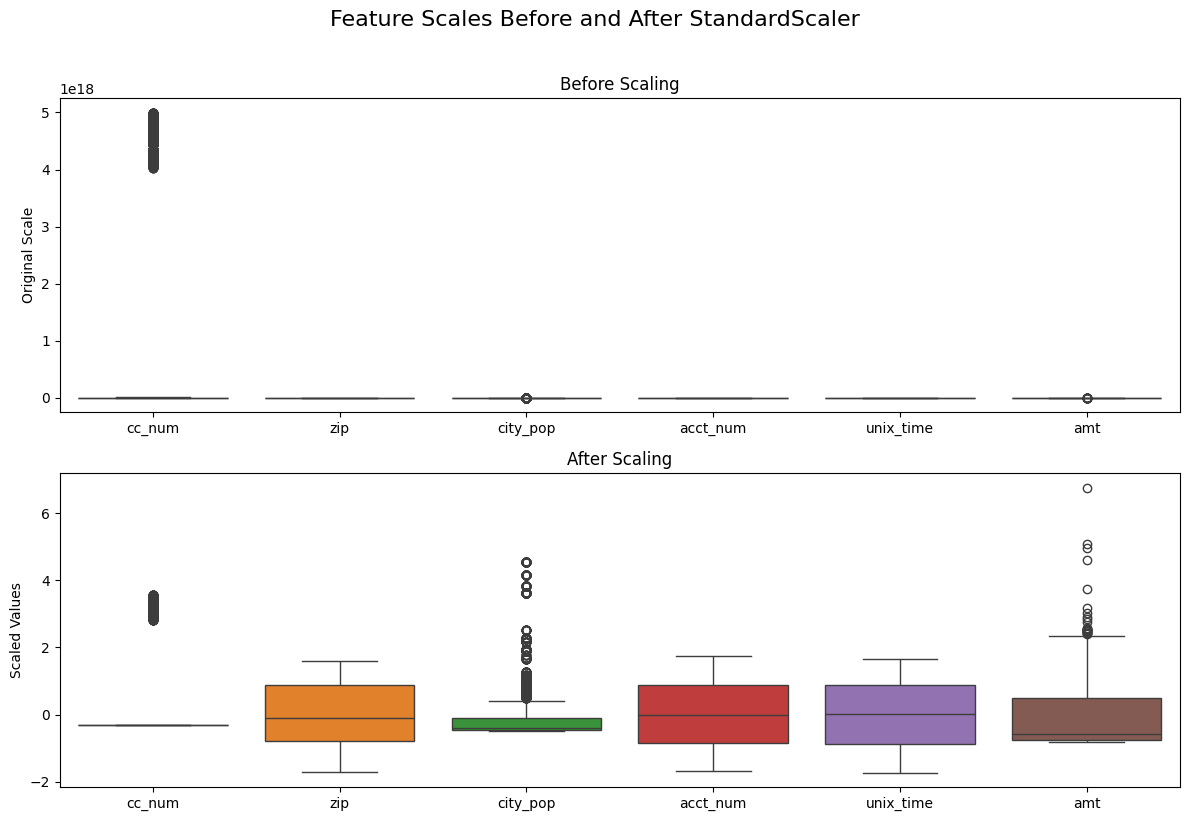

In [ ]:
def plot_scaling_boxplots(X_train, X_train_scaled, features_to_plot=3):

    # Convert scaled array back to dataframe with feature names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

    # Select only numeric columns
    numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
    selected_features = numeric_cols[:features_to_plot]

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle('Feature Scales Before and After StandardScaler', fontsize=16, y=1.02)

    # Original data boxplot
    sns.boxplot(data=X_train[selected_features], ax=ax1)
    ax1.set_title('Before Scaling')
    ax1.set_ylabel('Original Scale')

    # Scaled data boxplot
    sns.boxplot(data=X_train_scaled_df[selected_features], ax=ax2)
    ax2.set_title('After Scaling')
    ax2.set_ylabel('Scaled Values')

    plt.tight_layout()
    plt.show()

plot_scaling_boxplots(X_train, X_train_scaled , 7)

**Interpreting Our Plots:**

>**Before Scaling (Top Plot):**
<br>Notice the dramatic difference in scales across features. The `cc_num` (credit card number) feature has values in the range of 4-5×10^18 (quintillions!), while features like `city_pop`, `acct_num`, `unix_time`, and `amt` (transaction amount) are barely visible near zero. This extreme disparity would cause the SVM to be dominated by the large-scale features, essentially ignoring the smaller ones that might contain crucial fraud patterns.

>**After Scaling (Bottom Plot):**
<br>All features are now centered around zero with comparable scales (roughly -2 to +6). Each feature has been standardized to have a mean of 0 and standard deviation of 1, making them directly comparable. The box plots now show similar distributions, ensuring that all features contribute equally to the SVM's decision-making process. Notice that outliers are still preserved (shown as individual points), which is important for fraud detection where unusual values often signal fraudulent activity.

This transformation is essential for our SVM to learn meaningful patterns from all features, not just those with the largest numerical values.

# 4. Model Building and Evaluation

We will keep the same SVM model with the same parameters as our last exercise to showcase how fixing the class imbalance will affect the performance of the model.

In [ ]:
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(random_state=42)

We evaluate the model using the testing set.

In [ ]:
# Evaluate SVM Model
y_pred = svm_model.predict(X_test_scaled)

The accuracy score is a metric that evaluates how well the model's predictions match the actual labels of the data. It is calculated as the ratio of correctly predicted instances to the total number of instances in the dataset.
$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} = \frac{\sum_{i=1}^{n} \mathbb{1}(y_{\text{true},i} = y_{\text{pred},i})}{n}
$$

<br>For a perfect model, the accuracy score is 1. Now, we calculate the accuracy of our SVM model.

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8115
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1007
           1       0.84      0.77      0.80       993

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



>- **Precision:** a metric that answers the question: "Of all the instances the model predicted as positive, how many were actually positive?"
 $$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

>- **Recall:** a metric that answers the question: "Of all the actual positive instances, how many did the model correctly identify?"
$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

>- **F1 score:** the harmonic mean of precision and recall. It provides a single metric that balances precision and recall, especially when you need to account for both false positives and false negatives.
$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

# 5. Visualization of Results

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

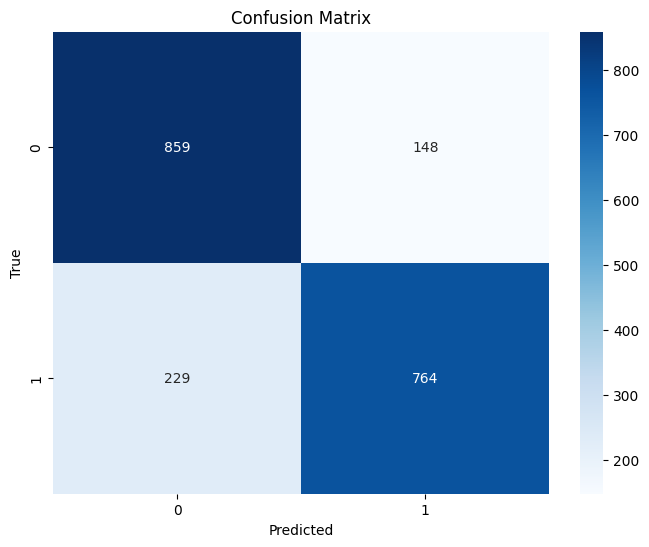

In [ ]:
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix')

**Results: A Significant Improvement**

Our enhanced preprocessing pipeline with feature scaling and class imbalance handling has dramatically improved the model's ability to detect fraud.

The model is now actually functioning as a fraud detector. While we're seeing some trade-offs, this is a massive improvement over catching zero frauds. The model has learned to recognize fraud patterns and achieves a decent fraud detection rate.

The false positives represent legitimate transactions that may inconvenience customers, but this is an acceptable trade-off compared to the alternative of missing all fraudulent activity. In practice, these flagged transactions can undergo additional verification before being blocked.

This demonstrates the critical importance of addressing class imbalance and proper feature scaling in machine learning applications, especially for imbalanced real-world problems like fraud detection.